In [1]:
%matplotlib ipympl
import wgpu
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import math
import time
import asyncio
from collections import namedtuple
from tqdm import tqdm
from contextlib import contextmanager, nullcontext, asynccontextmanager

In [2]:
adapter_0 = wgpu.gpu.request_adapter_sync(power_preference="high-performance")
device_0 = adapter_0.request_device_sync(
    required_features=[wgpu.FeatureName.timestamp_query]
)
pprint(adapter_0.info)

adapter_1 = wgpu.gpu.request_adapter_sync(power_preference="low-power")
device_1 = adapter_1.request_device_sync(
    required_features=[wgpu.FeatureName.timestamp_query]
)
pprint(adapter_1.info)

{'adapter_type': 'IntegratedGPU',
 'architecture': '',
 'backend_type': 'Vulkan',
 'description': '24.12.1 (AMD proprietary shader compiler)',
 'device': 'AMD Radeon(TM) Graphics',
 'device_id': 5761,
 'vendor': 'AMD proprietary driver',
 'vendor_id': 4098}
{'adapter_type': 'IntegratedGPU',
 'architecture': '',
 'backend_type': 'Vulkan',
 'description': '24.12.1 (AMD proprietary shader compiler)',
 'device': 'AMD Radeon(TM) Graphics',
 'device_id': 5761,
 'vendor': 'AMD proprietary driver',
 'vendor_id': 4098}


In [4]:
if 0:
    adapter = adapter_0
    device = device_0
else:
    adapter = adapter_1
    device = device_1

pprint(adapter.info)

{'adapter_type': 'IntegratedGPU',
 'architecture': '',
 'backend_type': 'Vulkan',
 'description': '24.12.1 (AMD proprietary shader compiler)',
 'device': 'AMD Radeon(TM) Graphics',
 'device_id': 5761,
 'vendor': 'AMD proprietary driver',
 'vendor_id': 4098}


In [5]:
# x, y, z
# grid_size = [32, 128, 1024]
grid_size = [17, 107, 152]
total_cells = grid_size[0]*grid_size[1]*grid_size[2]

print(f"grid_size={grid_size}")
print(f"total_cells={total_cells}")

# create cpu side data
n_dims = 3
x_cpu = np.zeros(grid_size + [n_dims,], dtype=np.float32)
y_cpu = np.zeros(grid_size + [n_dims,], dtype=np.float32)

x = np.reshape(x_cpu, (n_dims*total_cells,))
x[:] = (-1.0*np.arange(0, n_dims*total_cells, dtype=np.float32) + 0.5) % 0.88490

# Create buffer objects, input buffer is mapped.
x_gpu = device.create_buffer_with_data(
    data=x_cpu.data, 
    usage=wgpu.BufferUsage.STORAGE | wgpu.BufferUsage.COPY_SRC | wgpu.BufferUsage.COPY_DST
)
y_gpu = device.create_buffer_with_data(
    data=y_cpu.data,
    usage=wgpu.BufferUsage.STORAGE | wgpu.BufferUsage.COPY_SRC | wgpu.BufferUsage.COPY_DST
)

grid_size=[17, 107, 152]
total_cells=276488


In [6]:
class UniformBuffer:
    def __init__(self, nbytes, device, label=None):
        self.nbytes = nbytes
        self.device = device
        self.label = label
        self.buffer = self.device.create_buffer(
            label=self.label,
            size=self.nbytes,
            usage=wgpu.BufferUsage.UNIFORM | wgpu.BufferUsage.COPY_DST
        )

    def update(self, data, dst_offset=0, src_offset=0, src_size=None):
        if src_size is None:
            src_size = data.nbytes
        self.device.queue.write_buffer(self.buffer, dst_offset, data, src_offset, src_size)

In [7]:
class CurlShader:
    def __init__(self, workgroup_size, device, label=None, loop_count=1):
        self.label = label or "curl_shader"
        self.device = device
        self.loop_count = loop_count
        self.workgroup_size = workgroup_size
        self.grid_size = np.array([0,0,0], dtype=np.uint32)
        self.grid_size_uniform = UniformBuffer(self.grid_size.nbytes, device, label="CurlShader.grid_size")
        self.grid_size_uniform.update(self.grid_size)
        self.n_dims = 3
        
        self.shader_source = f"""
            @group(0) @binding(0) var<uniform> grid_size: vec3<u32>;
            
            @group(0) @binding(1)
            var<storage,read> x: array<f32>;
            
            @group(0) @binding(2)
            var<storage,read_write> y: array<f32>;
            
            fn get_offset(i: vec3<u32>) -> u32 {{
                let x: u32 = i.x % grid_size.x;
                let y: u32 = i.y % grid_size.y;
                let z: u32 = i.z % grid_size.z;
                let offset: u32 = z + y*grid_size.z + x*grid_size.y*grid_size.z;
                return offset*{self.n_dims};
            }}
            
            @compute
            @workgroup_size({",".join(map(str, self.workgroup_size))})
            fn main(@builtin(global_invocation_id) i0: vec3<u32>) {{
                if (i0.x >= grid_size.x) {{ return; }}
                if (i0.y >= grid_size.y) {{ return; }}
                if (i0.z >= grid_size.z) {{ return; }}
                let i = get_offset(i0);
                let iz = get_offset(i0 + vec3(0,0,1));
                let iy = get_offset(i0 + vec3(0,1,0));
                let ix = get_offset(i0 + vec3(1,0,0));
                for (var j: u32 = 0; j < {self.loop_count}; j++) {{
                    y[i+0] += (x[i+2]-x[iy+2]) - (x[i+1]-x[iz+1]);
                    y[i+1] += (x[i+0]-x[iz+0]) - (x[i+2]-x[ix+2]);
                    y[i+2] += (x[i+1]-x[ix+1]) - (x[i+0]-x[iy+0]);
                }}
            }}
        """
        self.shader_module = self.device.create_shader_module(code=self.shader_source)
        self.binding_layouts = [
            {
                "binding": 0,
                "visibility": wgpu.ShaderStage.COMPUTE,
                "buffer": {
                    "type": wgpu.BufferBindingType.uniform,
                },
            },
            {
                "binding": 1,
                "visibility": wgpu.ShaderStage.COMPUTE,
                "buffer": {
                    "type": wgpu.BufferBindingType.read_only_storage,
                },
            },
            {
                "binding": 2,
                "visibility": wgpu.ShaderStage.COMPUTE,
                "buffer": {
                    "type": wgpu.BufferBindingType.storage,
                },
            },
        ]
        
        self.bind_group_layout = self.device.create_bind_group_layout(entries=self.binding_layouts)
        self.pipeline_layout = self.device.create_pipeline_layout(bind_group_layouts=[self.bind_group_layout])
        self.compute_pipeline = device.create_compute_pipeline(
            layout=self.pipeline_layout,
            compute={"module": self.shader_module, "entry_point": "main"},
        )

    def create_pass(self, command_encoder, x_gpu, y_gpu, grid_size, timestamp_writes=None):
        dispatch_size = [math.ceil(g/l) for g,l in zip(grid_size, self.workgroup_size)]
        if np.any(self.grid_size != grid_size):
            self.grid_size[:] = grid_size
            self.grid_size_uniform.update(self.grid_size)
        
        compute_pass = command_encoder.begin_compute_pass(label=self.label, timestamp_writes=timestamp_writes)
        compute_pass.set_pipeline(self.compute_pipeline)
        bindings = [
            {
                "binding": 0,
                "resource": {"buffer": self.grid_size_uniform.buffer, "offset": 0, "size": self.grid_size_uniform.buffer.size},
            },
            {
                "binding": 1,
                "resource": {"buffer": x_gpu, "offset": 0, "size": x_gpu.size},
            },
            {
                "binding": 2,
                "resource": {"buffer": y_gpu, "offset": 0, "size": y_gpu.size},
            },
        ]
        bind_group = self.device.create_bind_group(layout=self.bind_group_layout, entries=bindings)
        compute_pass.set_bind_group(0, bind_group)
        compute_pass.dispatch_workgroups(*dispatch_size)
        compute_pass.end()
        return compute_pass

In [8]:
class Timestamp:
    def __init__(self, start_ns, end_ns):
        self.start_ns = start_ns
        self.end_ns = end_ns

    def get_delta(self):
        return self.end_ns - self.start_ns

    @staticmethod
    def now():
        now = time.time_ns()
        return Timestamp(now, now)

class NanoTimer:
    def __init__(self):
        self.start_ns = None
        self.end_ns = None

    def __enter__(self):
        self.start_ns = time.time_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end_ns = time.time_ns()

    def probe_delta(self):
        end_ns = time.time_ns()
        return end_ns - self.start_ns

    def net_delta(self):
        return self.end_ns - self.start_ns

    def as_timestamp(self):
        return Timestamp(self.start_ns, self.end_ns)

In [9]:
class AsyncReadbackBuffer:
    def __init__(self, nbytes, device):
        self.device = device
        self.nbytes = nbytes
        self.event = asyncio.Event()
        self.event.set()
        self.buffer = self.device.create_buffer(
            size=self.nbytes,
            usage=wgpu.BufferUsage.MAP_READ | wgpu.BufferUsage.COPY_DST
        )

    def free(self):
        self.event.set()

    async def wait(self):
        await self.event.wait()
        self.event.clear()

class AsyncReadbackBuffers:
    def __init__(self, nbytes, depth, device):
        self.device = device
        self.nbytes = nbytes
        self.depth = depth
        self.buffers = []
        self.head_index = 0
        
        for _ in range(self.depth):
            self.buffers.append(AsyncReadbackBuffer(nbytes, device))

    async def acquire_buffer(self):
        index = self.head_index
        self.head_index = (self.head_index + 1) % self.depth
        buffer = self.buffers[index]
        await buffer.wait()
        return buffer

class BusyCount:
    def __init__(self):
        self.value = 0
        self.condition = asyncio.Condition()

    async def increment(self):
        async with self.condition:
            self.value += 1

    async def decrement(self):
        async with self.condition:
            self.value -= 1
            assert(self.value >= 0)
            self.condition.notify_all()

    async def wait_finished(self):
        async with self.condition:
            await self.condition.wait_for(lambda: self.value == 0)

class Benchmark:
    def __init__(self,
        total_passes=1, 
        max_samples=8192, min_samples=16, 
        sampling_timeout_ms=4000, 
        workgroup_size=[1,1,64],
        shader_loop_count=1,
        total_readback_buffers=3,
        debug=False,
        query_stride=None,
        transfer_size=None,
        sync_work_done=False,
        yield_loop=False,
    ):
        self.device = device
        self.total_passes = total_passes 
        self.max_samples = max_samples 
        self.min_samples = min_samples 
        self.sampling_timeout_ms = sampling_timeout_ms 
        self.workgroup_size = workgroup_size 
        self.total_readback_buffers = total_readback_buffers 
        self.debug = debug 
        self.query_stride = query_stride 
        self.transfer_size = transfer_size 
        self.sync_work_done = sync_work_done 
        self.yield_loop = yield_loop 

        self.curl_shader = CurlShader(workgroup_size, device, loop_count=shader_loop_count)
        self.net_timestamps = {}
        self.sample_timestamps = {}
        self.gpu_timestamps = {}
        self.cpu_timestamps = {}
        self.query_timestamps = {}
        self.transfer_timestamps = {}
        self.total_samples = 0

        self.query_gpu = query_stride != None
        self.force_transfer = transfer_size != None
        self.busy_count = BusyCount()

        if self.query_gpu:
            self.query_count = 2*self.total_passes
            self.query_cpu_buf = np.zeros((self.query_count,), dtype=np.uint64)
            self.query_set = device.create_query_set(type=wgpu.QueryType.timestamp, count=self.query_count)
            self.query_gpu_buf = device.create_buffer(
                size=self.query_cpu_buf.data.nbytes,
                usage=wgpu.BufferUsage.QUERY_RESOLVE | wgpu.BufferUsage.COPY_SRC,
            )
            self.query_gpu_bufs_readback = AsyncReadbackBuffers(self.query_cpu_buf.data.nbytes, self.total_readback_buffers, self.device)
    
        if self.force_transfer:
            self.Y_gpu_readback = AsyncReadbackBuffers(transfer_size, self.total_readback_buffers, self.device)
    
    @contextmanager
    def add_net_timestamp(self, label):
        start_ns = time.time_ns()
        try:
            yield start_ns
        finally:
            end_ns = time.time_ns()
            timestamp = Timestamp(start_ns, end_ns)
            self.net_timestamps.setdefault(label, []).append(timestamp)

    @contextmanager
    def add_sample_timestamp(self, label):
        start_ns = time.time_ns()
        try:
            yield start_ns
        finally:
            end_ns = time.time_ns()
            timestamp = Timestamp(start_ns, end_ns)
            self.sample_timestamps.setdefault(label, []).append(timestamp)
    
    @contextmanager
    def add_cpu_timestamp(self, label):
        start_ns = time.time_ns()
        try:
            yield start_ns
        finally:
            end_ns = time.time_ns()
            timestamp = Timestamp(start_ns, end_ns)
            self.cpu_timestamps.setdefault(label, []).append(timestamp)

    @contextmanager
    def add_query_timestamp(self, label):
        start_ns = time.time_ns()
        try:
            yield start_ns
        finally:
            end_ns = time.time_ns()
            timestamp = Timestamp(start_ns, end_ns)
            self.query_timestamps.setdefault(label, []).append(timestamp)

    @contextmanager
    def add_transfer_timestamp(self, label):
        start_ns = time.time_ns()
        try:
            yield start_ns
        finally:
            end_ns = time.time_ns()
            timestamp = Timestamp(start_ns, end_ns)
            self.transfer_timestamps.setdefault(label, []).append(timestamp)
    
    def create_timestamp_writes(self, index):
        offset = index*2
        return {
            "query_set": self.query_set,
            "beginning_of_pass_write_index": offset,
            "end_of_pass_write_index": offset+1,
        }
        
    def dprint(self, *args, **kwargs):
        if self.debug:
            print(*args, **kwargs)

    async def read_query(self, async_buffer, sample_index, buffer_index):
        self.dprint(f"[read-query-start] sample={sample_index}, buffer={buffer_index}")
        with self.add_query_timestamp("busy_increment"):
            await self.busy_count.increment()
            self.dprint(f"[read-query-busy] sample={sample_index}, buffer={buffer_index}")
    # with self.add_query_timestep("map_async"):
        buffer = async_buffer.buffer
        await buffer.map_async(wgpu.MapMode.READ, 0, buffer.size)
        self.dprint(f"[read-query-map-async] sample={sample_index}, buffer={buffer_index}")
    # with self.add_query_timestep("read_mapped"):
        memview = buffer.read_mapped(buffer_offset=0, size=buffer.size, copy=True)
        self.dprint(f"[read-query-read-mapped] sample={sample_index}, buffer={buffer_index}")
        cpu_queries = np.frombuffer(memview, dtype=np.uint64)
    # with self.add_query_timestep("unmap"):
        buffer.unmap()
        self.dprint(f"[read-query-unmap] sample={sample_index}, buffer={buffer_index}")
    # with self.add_query_timestep("signal_free"):
        async_buffer.free()
        self.dprint(f"[read-query-free] sample={sample_index}, buffer={buffer_index}")
    
    # with self.add_query_timestep("store_timestamps"):
        # TODO: supposed to get this view device.queue.get_timestamp_period but binding doesnt exist?
        scale = 10 
        end_ns = cpu_queries[1::2] * scale
        start_ns = cpu_queries[0::2] * scale
        for pass_index, (start, end) in enumerate(zip(start_ns, end_ns)):
            self.gpu_timestamps.setdefault(f"compute_pass_{pass_index}", []).append(Timestamp(start, end))
        with self.add_query_timestamp("busy_decrement"):
            await self.busy_count.decrement()
            self.dprint(f"[read-query-done] sample={sample_index}, buffer={buffer_index}")

    async def read_y_gpu(self, async_buffer, sample_index, buffer_index):
        self.dprint(f"[read-y-gpu-start] sample={sample_index}, buffer={buffer_index}")
        with self.add_transfer_timestamp("busy_increment"):
            await self.busy_count.increment()
            self.dprint(f"[read-y-gpu-busy] sample={sample_index}, buffer={buffer_index}")

        buffer = async_buffer.buffer
        with self.add_transfer_timestamp("map_async"):
            await buffer.map_async(wgpu.MapMode.READ, 0, buffer.size)
            self.dprint(f"[read-y-gpu-map] sample={sample_index}, buffer={buffer_index}")
        with self.add_transfer_timestamp("read_mapped"):
            memview = buffer.read_mapped(buffer_offset=0, size=buffer.size, copy=True)
            y_data = np.frombuffer(memview, dtype=y_cpu.dtype)
        with self.add_transfer_timestamp("unmap"):
            buffer.unmap()
            self.dprint(f"[read-y-gpu-unmap] sample={sample_index}, buffer={buffer_index}")
        with self.add_transfer_timestamp("signal_free"):
            async_buffer.free()
            self.dprint(f"[read-y-gpu-free] sample={sample_index}, buffer={buffer_index}")
        # TODO:
        with self.add_transfer_timestamp("busy_decrement"):
            await self.busy_count.decrement()
            self.dprint(f"[read-y-gpu-done] sample={sample_index}, buffer={buffer_index}")

    async def run(self):
        with self.add_net_timestamp("loop") as loop_start_ns:
            for sample_idx in tqdm(range(self.max_samples)):
                with self.add_sample_timestamp(f"sample_{sample_idx}"):
                    is_query = self.query_gpu and (sample_idx % self.query_stride == 0)
            
                    if self.yield_loop:
                        if is_query or self.force_transfer:
                            with self.add_cpu_timestamp("yield_loop"):
                                await asyncio.sleep(0)
                        elif self.query_gpu:
                            with self.add_cpu_timestamp("yield_loop"): pass
            
                    with self.add_cpu_timestamp("create_command_encoder"):
                        command_encoder = self.device.create_command_encoder()
                    
                    x0_gpu = x_gpu
                    y0_gpu = y_gpu
                    for curr_pass in range(self.total_passes):
                        if is_query:
                            timestamp_writes = self.create_timestamp_writes(curr_pass)
                        else:
                            timestamp_writes = None
                        with self.add_cpu_timestamp(f"compute_pass_{curr_pass}"):
                            compute_pass = self.curl_shader.create_pass(command_encoder, x0_gpu, y0_gpu, grid_size, timestamp_writes=timestamp_writes)
                        x0_gpu, y0_gpu = y0_gpu, x0_gpu
            
                    if is_query:
                        with self.add_cpu_timestamp("resolve_query_set"):
                            command_encoder.resolve_query_set(
                                query_set=self.query_set,
                                first_query=0,
                                query_count=self.query_count,
                                destination=self.query_gpu_buf,
                                destination_offset=0,
                            )
                    elif self.query_gpu:
                        with self.add_cpu_timestamp("resolve_query_set"): pass
                    
                    # NOTE: dummy copy to force each compute pass to actually be read
                    #       sometimes it doesn't actually invoke the compute pass without this???
                    #       the query numbers will just return 0 indicating nothing happened
                    if self.force_transfer:
                        y_gpu_readback_index = self.Y_gpu_readback.head_index
                        self.dprint(f"[compute-pass-wait-y-gpu] sample={sample_idx}, buffer={y_gpu_readback_index}")
                        with self.add_cpu_timestamp("wait_y_gpu_buf"):
                            y_gpu_readback = await self.Y_gpu_readback.acquire_buffer()
                            self.dprint(f"[compute-pass-acquired-y-gpu] sample={sample_idx}, buffer={y_gpu_readback_index}")
                        
                        with self.add_cpu_timestamp("copy_yout_buffer"):
                            command_encoder.copy_buffer_to_buffer(
                                #source=y_gpu,
                                source=x0_gpu,
                                source_offset=0,
                                destination=y_gpu_readback.buffer,
                                destination_offset=0,
                                #size=y_gpu.size,
                                size=y_gpu_readback.nbytes, # manually force each pass to be processed
                            )
                            self.dprint(f"[compute-pass-issue-copy-y-gpu] sample={sample_idx}, buffer={y_gpu_readback_index}")
                        
                    if is_query:
                        query_readback_index = self.query_gpu_bufs_readback.head_index
                        self.dprint(f"[compute-pass-wait-query] sample={sample_idx}, buffer={query_readback_index}")
                        with self.add_cpu_timestamp("wait_query_buf"):
                            query_gpu_readback = await self.query_gpu_bufs_readback.acquire_buffer()
                            self.dprint(f"[compute-pass-acquired-query] sample={sample_idx}, buffer={query_readback_index}")
                        
                        with self.add_cpu_timestamp("copy_query_buffer"):
                            command_encoder.copy_buffer_to_buffer(
                                source=self.query_gpu_buf,
                                source_offset=0,
                                destination=query_gpu_readback.buffer,
                                destination_offset=0,
                                size=self.query_gpu_buf.size
                            )
                            self.dprint(f"[compute-pass-issue-copy-query] sample={sample_idx}, buffer={query_readback_index}")
                    elif self.query_gpu:
                        with self.add_cpu_timestamp("wait_query_buf"): pass
                        with self.add_cpu_timestamp("copy_query_buffer"): pass
            
                    with self.add_cpu_timestamp("encoder_finish"):
                        commands = command_encoder.finish()
            
                    with self.add_cpu_timestamp("queue_submit"):
                        self.device.queue.submit([commands])
            
                    if self.sync_work_done:
                        with self.add_cpu_timestamp("work_sync"):
                            self.device.queue.on_submitted_work_done_sync()
            
                    if is_query:
                        self.dprint(f"[compute-pass-submit] sample={sample_idx}")
                        with self.add_cpu_timestamp("async_query_task"):
                            _query_task = asyncio.create_task(self.read_query(query_gpu_readback, sample_idx, query_readback_index))
                    elif self.query_gpu:
                        with self.add_cpu_timestamp("async_query_task"): pass
            
                    if self.force_transfer:
                        with self.add_cpu_timestamp("async_y_gpu_task"):
                            _gpu_task = asyncio.create_task(self.read_y_gpu(y_gpu_readback, sample_idx, y_gpu_readback_index))
                                                      
                    self.total_samples += 1
                    loop_delta_ns = time.time_ns() - loop_start_ns
                    if sample_idx >= self.min_samples and loop_delta_ns > self.sampling_timeout_ms*1e6:
                        print("Exceeded timeout limit for sample collection")
                        break
                    
        print("Finished issuing commands")
        
        if self.query_gpu or self.force_transfer:
            print("Waiting for async tasks")
            with self.add_net_timestamp("wait_async_finished"):
                await self.busy_count.wait_finished()
    
        print("Waiting for final sync")
        with self.add_net_timestamp("queue_work_sync"):
            await self.device.queue.on_submitted_work_done_async()
    
        print("Finished workload")

In [10]:
total_passes = 3
benchmark = Benchmark(
    total_passes=total_passes,
    max_samples=8192,
    min_samples=16,
    sampling_timeout_ms=10000,
    workgroup_size=[1,1,152],
    # workgroup_size=[1,2,256],
    shader_loop_count=1024,
    total_readback_buffers=5,
    debug=False,
    query_stride=1,
    # query_stride=10,
    #transfer_size=y_cpu.data.nbytes,
    transfer_size=4,
    sync_work_done=False,
    yield_loop=False,
)
await benchmark.run()
net_timestamps = benchmark.net_timestamps
sample_timestamps = benchmark.sample_timestamps
gpu_timestamps = benchmark.gpu_timestamps
cpu_timestamps = benchmark.cpu_timestamps
query_timestamps = benchmark.query_timestamps
transfer_timestamps = benchmark.transfer_timestamps
total_samples = benchmark.total_samples

  0%|          | 28/8192 [00:10<48:42,  2.79it/s]

Exceeded timeout limit for sample collection
Finished issuing commands
Waiting for async tasks


Waiting for final sync
Finished workload


In [11]:
flops_per_cell = 12

def read_timestamps(all_timestamps):
    # delta_ns = [np.array([t.get_delta() for t in timestamps]) for timestamps in all_timestamps]
    # max_samples = max((len(y) for y in delta_ns))
    # delta_ns = [np.pad(y, [(0, max_samples - len(y))], mode="constant", constant_values=0.0) for y in delta_ns]
    # delta_ns = np.array(delta_ns, dtype=np.float32)
    delta_ns = np.array([[t.get_delta() for t in timestamps] for timestamps in all_timestamps])
    return delta_ns

net_delta_ns = read_timestamps(net_timestamps.values())
net_delta_ns = np.sum(net_delta_ns)
net_delta_sample_ns = net_delta_ns / total_samples
net_cell_rate = total_cells / (net_delta_sample_ns*1e-9) * total_passes * benchmark.curl_shader.loop_count
net_flops = flops_per_cell*net_cell_rate

is_gpu_profiled = len(gpu_timestamps.values()) > 0
if is_gpu_profiled:
    gpu_delta_ns = read_timestamps(gpu_timestamps.values())
    gpu_delta_ns_avg = np.mean(gpu_delta_ns)
    gpu_cell_rate = total_cells / (gpu_delta_ns_avg*1e-9) * benchmark.curl_shader.loop_count
    gpu_flops = flops_per_cell*gpu_cell_rate

cpu_delta_ns = read_timestamps(cpu_timestamps.values())
cpu_delta_ns_avg = np.mean(np.sum(cpu_delta_ns, axis=0))
cpu_cell_rate = total_cells / (cpu_delta_ns_avg*1e-9) * total_passes * benchmark.curl_shader.loop_count
cpu_flops = flops_per_cell*cpu_cell_rate

print("### RESULTS ###")
print(f"cell_count={total_cells}")
print(f"total_samples={total_samples}")
print(f"total_passes={total_passes}")
print("=== Overall sim rate ===")
print(f"net_delta={net_delta_ns*1e-9:.3f} s")
print(f"net_delta_sample_ns={net_delta_sample_ns*1e-3:.3f} us")
print(f"net_cell_rate={net_cell_rate*1e-6:.3f} M/s")
print(f"net_flops={net_flops*1e-9:.3f} GFlops")
if is_gpu_profiled:
    print("=== GPU upper bound ===")
    print(f"gpu_delta_avg={gpu_delta_ns_avg*1e-3:.3f} us")
    print(f"gpu_cell_rate={gpu_cell_rate*1e-6:.3f} M/s")
    print(f"gpu_flops={gpu_flops*1e-9:.3f} GFlops")
    print(f"cpu_overhead={(1-net_flops/gpu_flops)*100:.3f}%")
print("=== CPU upper bound ===")
print(f"cpu_delta_avg={cpu_delta_ns_avg*1e-3:.3f} us")
print(f"cpu_cell_rate={cpu_cell_rate*1e-6:.3f} M/s")
print(f"cpu_flops={cpu_flops*1e-9:.3f} GFlops")

### RESULTS ###
cell_count=276488
total_samples=29
total_passes=3
=== Overall sim rate ===
net_delta=12.133 s
net_delta_sample_ns=418373.203 us
net_cell_rate=2030.176 M/s
net_flops=24.362 GFlops
=== GPU upper bound ===
gpu_delta_avg=136387.076 us
gpu_cell_rate=2075.884 M/s
gpu_flops=24.911 GFlops
cpu_overhead=2.202%
=== CPU upper bound ===
cpu_delta_avg=345507.362 us
cpu_cell_rate=2458.330 M/s
cpu_flops=29.500 GFlops


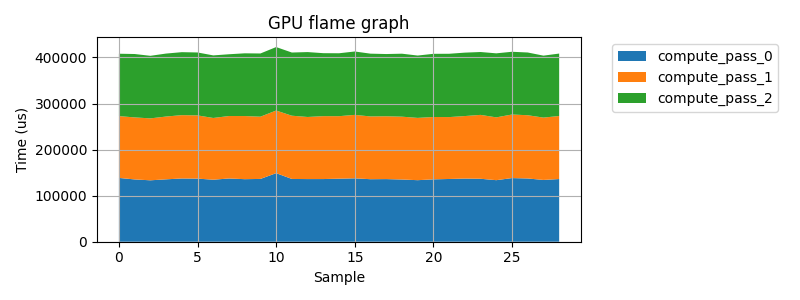

In [12]:
fig = plt.figure(figsize=(8,3))
N = gpu_delta_ns.shape[1]
i = slice(0, N)
X = np.arange(N)[i]
Y = gpu_delta_ns[:,i]
plt.stackplot(X, Y*1e-3, labels=gpu_timestamps.keys())
_ = plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.ylabel("Time (us)")
plt.xlabel("Sample")
plt.title("GPU flame graph")
plt.tight_layout()
plt.show()

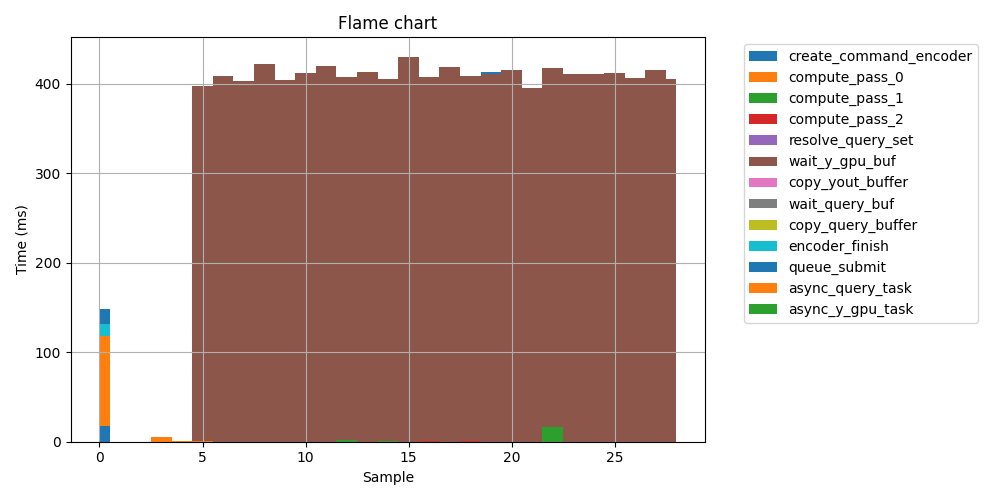

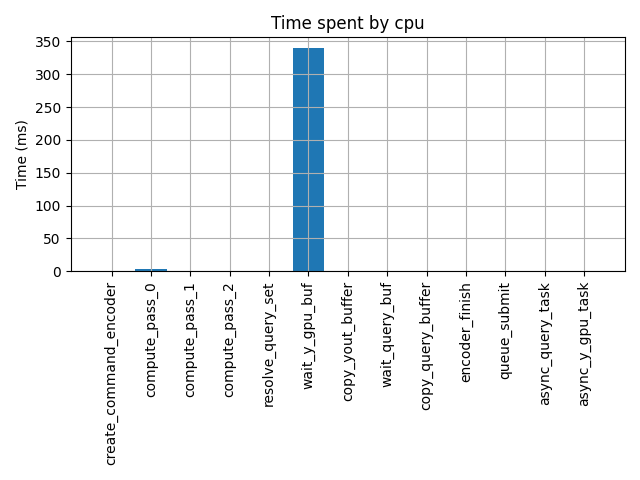

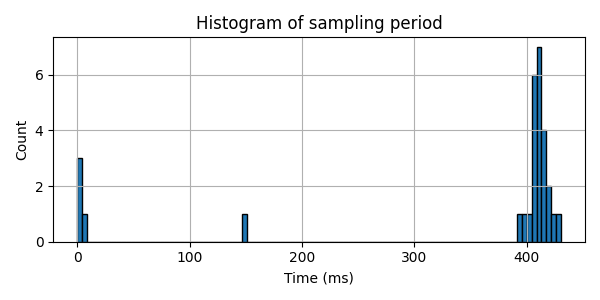

In [13]:
fig = plt.figure(figsize=(10,5))
N = cpu_delta_ns.shape[1]
#i = slice(200, 240, 1)
i = slice(0, N)
X = np.arange(N)[i]
Y = cpu_delta_ns[:,i]
plt.stackplot(X, Y*1e-6, labels=cpu_timestamps.keys(), step="mid")
_ = plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.title("Flame chart")
plt.ylabel("Time (ms)")
plt.xlabel("Sample")
plt.tight_layout()
plt.show()

plt.figure()
cpu_times_ns = np.mean(cpu_delta_ns*1e-6, axis=1)
plt.bar(np.arange(cpu_delta_ns.shape[0]), cpu_times_ns)
plt.xticks(np.arange(cpu_delta_ns.shape[0]), list(cpu_timestamps.keys()), rotation="vertical")
plt.title("Time spent by cpu")
plt.grid(True)
plt.ylabel("Time (ms)")
# plt.yticks(np.linspace(0, 1, 11, endpoint=True))
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.hist(np.sum(cpu_delta_ns*1e-6, axis=0), bins=100, edgecolor="black")
plt.title("Histogram of sampling period")
plt.grid(True)
plt.ylabel("Count")
plt.xlabel("Time (ms)")
plt.tight_layout()
plt.show()

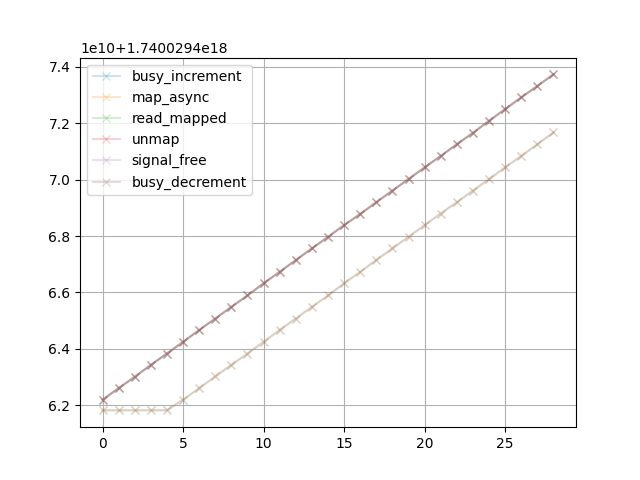

In [14]:
#timestamps = np.array([[t.get_delta() for t in timestamps] for timestamps in gpu_timestamps.values()])
all_timestamps = transfer_timestamps
timestamps = np.array([[t.start_ns for t in timestamps] for timestamps in all_timestamps.values()])
plt.figure()
x = np.arange(timestamps.shape[1])
for label, i in zip(all_timestamps.keys(), range(timestamps.shape[0])):
    _ = plt.plot(x, timestamps[i,:], label=label, alpha=0.2, marker="x")
plt.grid()
plt.legend()
plt.show()

In [15]:
def get_trace_events(all_timestamps, pid=1, tid=1):
    trace_events = []
    for label, timestamps in all_timestamps.items():
        for t in timestamps:
            if t.start_ns == 0: continue
            is_instant = t.end_ns == t.start_ns
            if is_instant: continue # doesn't show up properly
            ev = {
                "pid": pid,
                "tid": tid,
                "ts": (t.start_ns)*1e-3,
                "ph": "i" if is_instant else "X",
                "name": label,
            }
            if not is_instant:
                ev["dur"] = (t.end_ns-t.start_ns)*1e-3
            trace_events.append(ev)
    return trace_events

gpu_trace_events = get_trace_events(gpu_timestamps, pid=1, tid=1)
net_trace_events = get_trace_events(net_timestamps, pid=2, tid=1)
sample_trace_events = get_trace_events(sample_timestamps, pid=2, tid=1)
cpu_trace_events = get_trace_events(cpu_timestamps, pid=2, tid=2)
query_trace_events = get_trace_events(query_timestamps, pid=2, tid=3)
transfer_trace_events = get_trace_events(transfer_timestamps, pid=2, tid=4)

gpu_start_us = min((ev["ts"] for ev in gpu_trace_events))
gpu_end_us = max((ev["ts"] + ev["dur"] for ev in gpu_trace_events))
gpu_span_us = gpu_end_us - gpu_start_us
gpu_used_us = sum((ev["dur"] for ev in gpu_trace_events))
gpu_miss_us = gpu_span_us - gpu_used_us
gpu_util_rate = gpu_used_us / gpu_span_us
print(f"gpu_span={gpu_span_us*1e-6:.3f}s")
print(f"gpu_used={gpu_used_us*1e-6:.3f}s")
print(f"gpu_miss={gpu_miss_us*1e-6:.3f}s")
print(f"gpu_util={gpu_util_rate*100:.2f}%")

gpu_delta_us_avg = gpu_span_us / total_samples
gpu_cell_rate = total_cells / (gpu_delta_us_avg*1e-6) * total_passes * benchmark.curl_shader.loop_count
gpu_flops = flops_per_cell*gpu_cell_rate
print(f"gpu_delta_avg={gpu_delta_us_avg:.3f}us")
print(f"gpu_cell_rate={gpu_cell_rate*1e-6:.3f} M/s")
print(f"gpu_flops={gpu_flops*1e-9:.3f} GFlops")

cpu_start_us = min((ev["ts"] for ev in cpu_trace_events))

for ev in gpu_trace_events: ev["ts"] -= gpu_start_us
for ev in cpu_trace_events: ev["ts"] -= cpu_start_us
for ev in net_trace_events: ev["ts"] -= cpu_start_us
for ev in sample_trace_events: ev["ts"] -= cpu_start_us
for ev in query_trace_events: ev["ts"] -= cpu_start_us
for ev in transfer_trace_events: ev["ts"] -= cpu_start_us

trace_events = []
trace_events.extend(gpu_trace_events) 
trace_events.extend(cpu_trace_events)
trace_events.extend(net_trace_events)
trace_events.extend(sample_trace_events)
trace_events.extend(query_trace_events)
trace_events.extend(transfer_trace_events)

gpu_span=11.925s
gpu_used=11.866s
gpu_miss=0.059s
gpu_util=99.50%
gpu_delta_avg=411199.315us
gpu_cell_rate=2065.595 M/s
gpu_flops=24.787 GFlops


In [16]:
import json
with open("trace.json", "w+", encoding='utf-8') as fp:
    data = { "traceEvents": trace_events }
    json.dump(data, fp, indent=1)